In [1]:
## CCXP Roberta: Quality Assurance >2
## This script utilizes the CCXP ML Model to train on the CCXP dataset for all jira bug tickets
#3 with > 2 Quality Assurance Indicators

In [ ]:
# Import libraries
from simpletransformers.classification import MultiLabelClassificationModel
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier

In [2]:
from transformers import set_seed
set_seed(42)

In [ ]:
import os
os.getcwd()

Input data are available for the following locations
1. AWS S3 bucket
2. Github /data folder
3. RDS MySQL database table

In [3]:
# 9 Categories
## Pull in raw data
# this is the file with one git file change per line
commit=pd.read_csv(r'WETG_AI_ML_BUG_AUTO_CCXP_Jira_Github_Commit_Dataset.csv') 
## drop rows where summary and descriptions columns are blank
commit=commit.dropna(subset=['summary','description'], how='all')

In [4]:
ccxp_QA=pd.read_csv(r'WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2.csv') 
commit_QA2=commit.loc[commit['jira_ticket'].isin(ccxp_QA['jira_ticket'])]
commit_QA2=commit_QA2.reset_index(drop=True)
# create a column that adds the repo name to the directory for label preparation
commit_QA2['filepath'] = commit_QA2['repo'] + '/'+commit_QA2['filename']

In [5]:
## count the number of jira ticket changes, additions, deletions of mct bug dataset
ticket_changes= commit_QA2.pivot_table(index=['jira_ticket'],values=['additions','changes','deletions'],aggfunc=sum)
raw_change_count=ticket_changes.changes.sum()
raw_additions_cnt=ticket_changes.additions.sum()
raw_del_count=ticket_changes.deletions.sum()                                       
print('Count of total ticket changes on raw dataset: ',raw_change_count)
print('Count of total  ticket additions on raw dataset: ',raw_additions_cnt)
print('Count of total  ticket additions on raw dataset: ',raw_del_count)    

Count of total ticket changes on raw dataset:  301412
Count of total  ticket additions on raw dataset:  144069
Count of total  ticket additions on raw dataset:  157343


In [6]:
## length of each directory utilized in bug jira tickets
print('CCXP Dataset Length: ',len(commit_QA2))
print('Unqiue Filename count: ',commit_QA2['filename_wo_path'].nunique())
print('Unique FILEPATH Count: ',commit_QA2['filepath'].nunique())
print('')
print('Filename -with filepath- specific length:')
print('1a. ccxp-server/src' ,len(commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-server/src')]))
print('1b. ccxp-server/' ,len(commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-server/')]))
print('2a. ccxp-data/data/src length:',len(commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-data/src')]))
print('2b. ccxp-data/ length:',len(commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-data')]))
print('3a. ccxp-etl/src length:',len(commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-etl/src')]))
print('3b. ccxp-etl/ length:',len(commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-etl/')]))
print('4. ccxp-client/apps/ccxp-web/src/scss length:',len(commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-client/apps/ccxp-web/src/scss')]))
print('5. ccxp-client/apps/ccxp-web/src/app length:',len(commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-client/apps/ccxp-web/src/app')]))
print('6. ccxp-client/libs/shared/src length:',len(commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-client/libs/shared/src')]))
print('7. ccxp-client/libs/features/provider-length:',len(commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-client/libs/features/provider-')]))
print('8a. ccxp-client/libs/core/src length:',len(commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-client/libs/core/src')]))
print('8b. ccxp-client/libs/core length:',len(commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-client/libs/core/')]))
print('9.ccxp-client/libs/mymedicare/',len(commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-client/libs/mymedicare/')]))


CCXP Dataset Length:  3048
Unqiue Filename count:  1314
Unique FILEPATH Count:  1633

Filename -with filepath- specific length:
1a. ccxp-server/src 121
1b. ccxp-server/ 193
2a. ccxp-data/data/src length: 348
2b. ccxp-data/ length: 371
3a. ccxp-etl/src length: 59
3b. ccxp-etl/ length: 75
4. ccxp-client/apps/ccxp-web/src/scss length: 103
5. ccxp-client/apps/ccxp-web/src/app length: 72
6. ccxp-client/libs/shared/src length: 120
7. ccxp-client/libs/features/provider-length: 1141
8a. ccxp-client/libs/core/src length: 315
8b. ccxp-client/libs/core length: 330
9.ccxp-client/libs/mymedicare/ 197


In [7]:
#df_ccxp_raw_new.loc[df_ccxp_raw_new.filepath.str.contains('ccxp-data/')].to_csv(r'ccxp-data_validate.csv')
#len(df_ccxp_raw_new.loc[df_ccxp_raw_new.filepath.str.contains('ccxp-data/src/models')]) 
#len(df_ccxp_raw_new.loc[df_ccxp_raw_new.filepath.str.contains('ccxp-data/src/constants')])
#len(df_ccxp_raw_new.loc[df_ccxp_raw_new.filepath.str.contains('ccxp-data/src/schemas')])
#len(df_ccxp_raw_new.loc[df_ccxp_raw_new.filepath.str.contains('ccxp-data/src/repositories')])
#len(df_ccxp_raw_new.loc[df_ccxp_raw_new.filepath.str.contains('ccxp-data/src/seeders')])
#len(df_ccxp_raw_new.loc[df_ccxp_raw_new.filepath.str.contains('ccxp-data/src/migrations')])
#len(df_ccxp_raw_new.loc[df_ccxp_raw_new.filepath.str.contains('ccxp-data/src/cli')])

In [8]:
## count the number of jira ticket changes, additions, deletions of mct bug dataset
ticket_changes= commit_QA2.pivot_table(index=['jira_ticket'],values=['additions','changes','deletions'],aggfunc=sum)

In [9]:
ticket_changes.additions.nunique()

99

In [10]:
ticket_changes.changes.nunique()

105

In [11]:
ticket_changes.deletions.nunique()

81

In [12]:
## Label the categories: Binarization
commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-server/src'),'server']=int(bool(1))
commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-data/src'),'data']=int(bool(1))
commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-etl/src'),'etl']=int(bool(1))
commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-client/libs/features/provider-compare/'),'pcompare']=int(bool(1))
commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-client/libs/features/provider-details/'),'pdetails']=int(bool(1))
commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-client/libs/features/provider-search/'),'psearch']=int(bool(1))
commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-client/libs/features/provider-measures/'),'pmeasures']=int(bool(1))
commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-client/apps'),'apps']=int(bool(1))
commit_QA2.loc[commit_QA2.filepath.str.contains('ccxp-client/libs/core'),'cl_core']=int(bool(1))

In [13]:
# Select the training data by choosing the rows that have category flags
df_training = commit_QA2.loc[~(commit_QA2.server.isna()\
                &(commit_QA2.data.isna())\
                &(commit_QA2.etl.isna())\
                &(commit_QA2.pcompare.isna())\
                &(commit_QA2.pdetails.isna())\
                &(commit_QA2.psearch.isna())\
                &(commit_QA2.pmeasures.isna())\
                &(commit_QA2.apps.isna())\
                &(commit_QA2.cl_core.isna()))]
##QA Tickets
#df_ccxp_raw_new_out= df_training.loc[:,['jira_ticket', 'summary', 'description']].groupby(['jira_ticket',
#                                'summary',
#                                'description'],
#                       ).max().reset_index().fillna(0)
#df_ccxp_raw_new_out.to_csv('CCXP_QA2_jira_tickets.csv')


In [14]:
print('QA2 Filtered dataset length: ',len(df_training))
print('ccxp raw dataset: ',len(commit_QA2))

training dataset length:  2237
ccxp raw dataset:  3048


In [15]:
# Group the training data by jira ticket number
df_training = df_training.loc[:,['jira_ticket', 'summary', 'description',
                                 'server', 'data',
                                   'etl','pcompare','pdetails','psearch',
                                 'pmeasures','apps','cl_core']].groupby(['jira_ticket',
                                'summary',
                                'description'],
                       ).max().reset_index().fillna(0)

In [16]:
print(df_training.shape)
print('length of training dataframe ',df_training['jira_ticket'].nunique())
print('df_training_count_unique tickets by column', df_training.sum())

(153, 12)
length of training dataframe  153
df_training_count_unique tickets by column jira_ticket    CCXP-1128CCXP-1348CCXP-1499CCXP-1687CCXP-1698C...
summary        Accessing Test and Impl using IE is not workin...
description    I should be able to access both Test and Impl ...
server                                                       4.0
data                                                        34.0
etl                                                          6.0
pcompare                                                    37.0
pdetails                                                    28.0
psearch                                                     46.0
pmeasures                                                   40.0
apps                                                        61.0
cl_core                                                     25.0
dtype: object


In [17]:
# Set the inputs columns and the columns that we want to predit
df_training['text']=df_training['summary'].apply(lambda x: x.replace(' \n ', '  '))+'  '+df_training['description'].apply(lambda x: x.replace(' \n ', '  '))
df_training['labels'] = list(zip(df_training.server.tolist(),  df_training.data.tolist(), df_training.etl.tolist(),
                                df_training.pcompare.tolist(),df_training.pdetails.tolist(),df_training.psearch.tolist(),
                                df_training.pmeasures.tolist(),df_training.apps.tolist(),df_training.cl_core.tolist()))

In [18]:
df_training['text']=df_training['text'].apply(lambda x: x.strip())
df_training['text']=df_training['text'].apply(lambda x: x.lower())

In [19]:
## Train/Test split
train_df, eval_df = train_test_split(df_training, test_size=0.2, random_state=4)

In [20]:
df_training.to_csv(r'WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_PREP_DATASET.csv')

In [21]:
train_df.to_csv(r'WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_TRAIN_DF.csv')

In [22]:
eval_df.to_csv(r'WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_EVAL_DF.csv')

In [23]:
## Analyze unique values per column to consider categorical variables for model predictions
cols =df_training.columns
label_cols = list(cols[0:])
num_labels = len(label_cols)
print('Count of distinct values per column: ',df_training[label_cols].nunique().sort_values().to_string())

Count of distinct values per column:  server           2
data             2
etl              2
pcompare         2
pdetails         2
psearch          2
pmeasures        2
apps             2
cl_core          2
labels          41
jira_ticket    153
summary        153
description    153
text           153


In [24]:
print(df_training.shape)
print('length of CCXP QA2 training dataframe ',df_training['jira_ticket'].nunique())

(153, 14)
length of training dataframe  153


In [25]:
df_training.sum()

jira_ticket    CCXP-1128CCXP-1348CCXP-1499CCXP-1687CCXP-1698C...
summary        Accessing Test and Impl using IE is not workin...
description    I should be able to access both Test and Impl ...
server                                                       4.0
data                                                        34.0
etl                                                          6.0
pcompare                                                    37.0
pdetails                                                    28.0
psearch                                                     46.0
pmeasures                                                   40.0
apps                                                        61.0
cl_core                                                     25.0
text           accessing test and impl using ie is not workin...
labels         (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
dtype: object

In [26]:
print('CCXP_QA2_average sentence length: ', df_training.text.str.split().str.len().mean())
print('CCXP_QA2_stdev sentence length: ', df_training.text.str.split().str.len().std())

average sentence length:  118.38562091503267
stdev sentence length:  118.36096241354501


In [27]:
train_df.shape

(122, 14)

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel

In [29]:
model_roberta = MultiLabelClassificationModel('roberta', 
                                      'roberta-base', 
                                      num_labels=9, 
                                      use_cuda= False,
                                      args={'train_batch_size':2, 'gradient_accumulation_steps':6, 
                                            'learning_rate': 3e-5,#'optimizer': optimizer,
                                            'num_train_epochs': 10,"weight_decay": 0, 'max_seq_length': 512,
                                            'overwrite_output_dir': True,'reprocess_input_data': True})


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'c

In [30]:
model_roberta.train_model(train_df,
                 no_deprecation_warning=True)

  0%|          | 0/122 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/61 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/61 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/61 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/61 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/61 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/61 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/61 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/61 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/61 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/61 [00:00<?, ?it/s]

(100, 0.4725548941269517)

In [31]:
result, model_outputs, wrong_predictions = model_roberta.eval_model(eval_df, 
                                            verbose=False, multi_label=True)

  0%|          | 0/31 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

In [32]:
result

{'LRAP': 0.596579255358057, 'eval_loss': 0.4850955978035927}

In [33]:
roberta_out=pd.concat([eval_df, pd.DataFrame(model_outputs)], axis=1,join='inner')

In [34]:
roberta_out.to_csv(r'WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_OUTPUT.csv')

In [35]:
roberta_out.columns

Index(['jira_ticket',     'summary', 'description',      'server',
              'data',         'etl',    'pcompare',    'pdetails',
           'psearch',   'pmeasures',        'apps',     'cl_core',
              'text',      'labels',             0,             1,
                   2,             3,             4,             5,
                   6,             7,             8],
      dtype='object')

In [36]:
roberta_test = roberta_out.loc[:,['server','data','etl','pcompare','pdetails','psearch','pmeasures','cl_core','apps',
                                  0,1,2,3,4,5,6,7,8]]

In [37]:
roberta_test.to_csv(r'WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_RESULTS.csv')

In [38]:
# preds for entire roberta model
import numpy as np
roberta_val=list(zip(roberta_out[0].tolist(), roberta_out[1].tolist(),
                   roberta_out[2].tolist(),roberta_out[3].tolist(),
                    roberta_out[4].tolist(),roberta_out[5].tolist(),
                    roberta_out[6].tolist(), roberta_out[7].tolist(),
                   roberta_out[8].tolist()))
roberta_true=list(zip(roberta_out.server.tolist(), roberta_out.data.tolist(), 
                roberta_out.etl.tolist(),
                roberta_out.pcompare.tolist(),
                roberta_out.pdetails.tolist(),
                roberta_out.psearch.tolist(),
               roberta_out.pmeasures.tolist(),
                roberta_out.cl_core.tolist(),
               roberta_out.apps.tolist()))
                     
roberta_pred=[]
for sample in roberta_val:
  roberta_pred.append([1 if i>=0.7 else 0 for i in sample ] )
roberta_pred = np.array(roberta_pred)
#roberta_pred

import numpy as np
from sklearn.metrics import accuracy_score
roberta_model_accuracy=accuracy_score(roberta_true, roberta_pred)
print('Roberta model accuracy:', roberta_model_accuracy)

Roberta model accuracy: 0.0


In [39]:
#1. 'server',
roberta_server_true=list(zip(roberta_out.server.tolist()))
roberta_server_score= list(zip(roberta_out[0].tolist()))
#2. 'data',
roberta_data_true=list(zip(roberta_out.data.tolist()))
roberta_data_score=list(zip(roberta_out[1].tolist()))
#3. 'etl',
roberta_etl_true=list(zip(roberta_out.etl.tolist()))
roberta_etl_score=list(zip(roberta_out[2].tolist()))
#4. 'ca_scss',pcompare
roberta_pcompare_true=list(zip(roberta_out.pcompare.tolist()))
roberta_pcompare_score=list(zip(roberta_out[3].tolist()))
#5. 'ca_webapp', pdetails
roberta_pdetails_true=list(zip(roberta_out.pdetails.tolist()))
roberta_pdetails_score=list(zip(roberta_out[4].tolist()))
#6. 'cl_shared',psearch
roberta_psearch_true=list(zip(roberta_out.psearch.tolist()))
roberta_psearch_score=list(zip(roberta_out[5].tolist()))
#7. 'cl_provider', pmeasures
roberta_pmeasures_true=list(zip(roberta_out.pmeasures.tolist()))
roberta_pmeasures_score=list(zip(roberta_out[6].tolist()))
#8. 'cl_core',
roberta_cl_core_true=list(zip(roberta_out.cl_core.tolist()))
roberta_cl_core_score=list(zip(roberta_out[7].tolist()))
#9. 'cl_mymedicare',apps
roberta_apps_true=list(zip(roberta_out.apps.tolist()))
roberta_apps_score=list(zip(roberta_out[8].tolist()))


## Predictions at Threshold .7 and Confusion Matrix Preparation

In [42]:
import numpy as np
########################################################
####### Label 1: Server
# Pred Binary Conversion at Threshold .7
roberta_server_pred=[]
for sample in roberta_server_score:
  roberta_server_pred.append([1 if i>=0.7 else 0 for i in sample ] )
roberta_server_pred = np.array(roberta_server_pred)

## Create Confusion Matrix for Label
ccxp_server_cm = multilabel_confusion_matrix(roberta_server_true,roberta_server_pred)
ccxp_server_cm_plt=ccxp_server_cm.reshape(2,2)

########################################################
###### Label 2: Data
# Pred Binary Conversion at Threshold .7
roberta_data_pred=[]
for sample in roberta_data_score:
  roberta_data_pred.append([1 if i>=0.7 else 0 for i in sample ] )
roberta_data_pred = np.array(roberta_data_pred)

## Creation Confusion Matrix for Label
ccxp_data_cm = confusion_matrix(roberta_data_true,roberta_data_pred)
ccxp_data_cm_plt=ccxp_data_cm.reshape(2,2)

########################################################
##### Label 3: Etl
# Pred Binary Conversion at Threshold .7
roberta_etl_pred=[]
for sample in roberta_etl_score:
  roberta_etl_pred.append([1 if i>=0.7 else 0 for i in sample ] )
roberta_etl_pred = np.array(roberta_etl_pred)

# Creation Confusion Matrix for Label
ccxp_etl_cm = confusion_matrix(roberta_etl_true,roberta_etl_pred)
ccxp_etl_cm_plt=ccxp_etl_cm.reshape(2,2)

########################################################
###### Label 4: Provider Compare
# Pred Binary Conversion at Threshold .7
roberta_pcompare_pred=[]
for sample in roberta_pcompare_score:
  roberta_pcompare_pred.append([1 if i>=0.7 else 0 for i in sample ] )
roberta_pcompare_pred = np.array(roberta_pcompare_pred)

# Creation Confusion Matrix for Label
ccxp_pcompare_cm = confusion_matrix(roberta_pcompare_true,roberta_pcompare_pred)
ccxp_pcompare_cm_plt=ccxp_pcompare_cm.reshape(2,2)

##########################################################
######### Label 5 Provider Details
# a. Pred Binary Conversion at Threshold .7
roberta_pdetails_pred=[]
for sample in roberta_pdetails_score:
  roberta_pdetails_pred.append([1 if i>=0.7 else 0 for i in sample ] )
roberta_pdetails_pred = np.array(roberta_pdetails_pred)

# b. Creation Confusion Matrix for Label
ccxp_pdetails_cm = multilabel_confusion_matrix(roberta_pdetails_true,roberta_pdetails_pred)
ccxp_pdetails_cm_plt=ccxp_pdetails_cm.reshape(2,2)

########################################################
######## Label 6. Client Provider search
# a. Prediction conversion at Threshold .7
roberta_psearch_pred=[]
for sample in roberta_psearch_score:
  roberta_psearch_pred.append([1 if i>=0.7 else 0 for i in sample ] )
roberta_psearch_pred = np.array(roberta_psearch_pred)

# b. Creation Confusion Matrix for Label
ccxp_psearch_cm = confusion_matrix(roberta_psearch_true,roberta_psearch_pred)
ccxp_psearch_cm_plt=ccxp_psearch_cm.reshape(2,2)

########################################################
########## Label 7: Client Libs Provider Measures
roberta_pmeasures_pred=[]
for sample in roberta_pmeasures_score:
  roberta_pmeasures_pred.append([1 if i>=0.7 else 0 for i in sample ] )
roberta_pmeasures_pred = np.array(roberta_pmeasures_pred)

# c. Creation Confusion Matrix for Label
ccxp_pmeasures_cm = confusion_matrix(roberta_pmeasures_true,roberta_pmeasures_pred)
ccxp_pmeasures_cm_plt=ccxp_pmeasures_cm.reshape(2,2)

#########################################################
############ Label 8: Client Libs Core
roberta_cl_core_pred=[]
for sample in roberta_cl_core_score:
  roberta_cl_core_pred.append([1 if i>=0.7 else 0 for i in sample ] )
roberta_cl_core_pred = np.array(roberta_cl_core_pred)

# c. Creation Confusion Matrix for Client Libs Core Label
ccxp_cl_core_cm = confusion_matrix(roberta_cl_core_true,roberta_cl_core_pred)
ccxp_cl_core_cm_plt=ccxp_cl_core_cm.reshape(2,2)

#############################################################
############ Label 9 apps Label
roberta_apps_pred=[]
for sample in roberta_apps_score:
  roberta_apps_pred.append([1 if i>=0.7 else 0 for i in sample ] )
roberta_apps_pred = np.array(roberta_apps_pred)

# c. Create Confusion Matrix for apps Label
ccxp_apps_cm = confusion_matrix(roberta_apps_true,roberta_apps_pred)
ccxp_apps_cm_plt=ccxp_apps_cm.reshape(2,2)


## Plot Confusion Matrices for 9 Labels

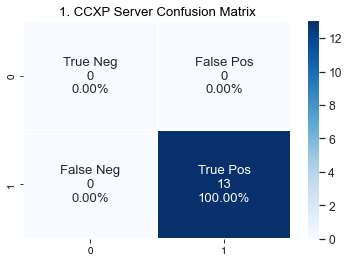

<Figure size 432x288 with 0 Axes>

In [43]:
import seaborn as sns
#Label 1: server
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                ccxp_server_cm_plt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     ccxp_server_cm_plt.flatten()/np.sum(ccxp_server_cm_plt)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.subplot()
sns.set(font_scale=1.1) #edited as suggested
ax = sns.heatmap(ccxp_server_cm_plt ,cmap='Blues', linewidth = 0.25 , fmt='',annot = labels)
plt.title( "1. CCXP Server Confusion Matrix" )
plt.show()
plt.savefig('WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_CM_1_server.png')

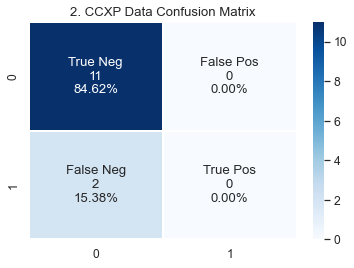

<Figure size 432x288 with 0 Axes>

In [44]:
# Label 2: data
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                ccxp_data_cm_plt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     ccxp_data_cm_plt.flatten()/np.sum(ccxp_data_cm_plt)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.subplot()
sns.set(font_scale=1.1) #edited as suggested
ax = sns.heatmap(ccxp_data_cm_plt ,cmap='Blues', linewidth = 0.25 , fmt='',annot = labels)
plt.title( "2. CCXP Data Confusion Matrix" )
plt.show()
plt.savefig('WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_CM_2_Data_Roberta.png')

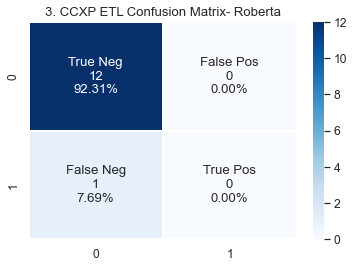

<Figure size 432x288 with 0 Axes>

In [45]:
# Label 3: etl
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                ccxp_etl_cm_plt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     ccxp_etl_cm_plt.flatten()/np.sum(ccxp_etl_cm_plt)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.subplot()
sns.set(font_scale=1.1) #edited as suggested
ax = sns.heatmap(ccxp_etl_cm_plt ,cmap='Blues', linewidth = 0.25 , fmt='',annot = labels)
plt.title( "3. CCXP ETL Confusion Matrix- Roberta" )
plt.show()
plt.savefig('WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_CM_3_etl.png')

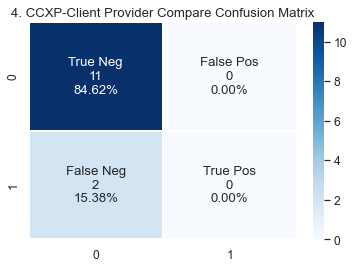

<Figure size 432x288 with 0 Axes>

In [46]:
# Label 4: pcompare
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                ccxp_pcompare_cm_plt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     ccxp_pcompare_cm_plt.flatten()/np.sum(ccxp_pcompare_cm_plt)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.subplot()
sns.set(font_scale=1.1) #edited as suggested
ax = sns.heatmap(ccxp_pcompare_cm_plt ,cmap='Blues', linewidth = 0.25 , fmt='',annot = labels)
plt.title( "4. CCXP-Client Provider Compare Confusion Matrix" )
plt.show()
plt.savefig('WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_CM_4_provider_compare.png')

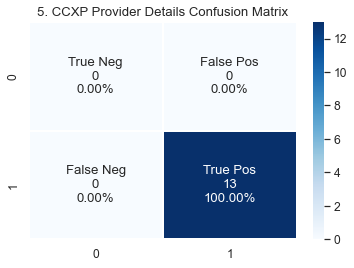

<Figure size 432x288 with 0 Axes>

In [47]:
# Label 5: pdetails
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                ccxp_pdetails_cm_plt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     ccxp_pdetails_cm_plt.flatten()/np.sum(ccxp_pdetails_cm_plt)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.subplot()
sns.set(font_scale=1.1) #edited as suggested
ax = sns.heatmap(ccxp_pdetails_cm_plt ,cmap='Blues', linewidth = 0.25 , fmt='',annot = labels)
plt.title( "5. CCXP Provider Details Confusion Matrix" )
plt.show()
plt.savefig('WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_CM_5_provider_details.png')

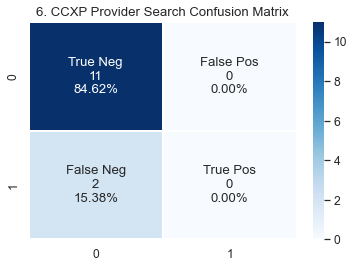

<Figure size 432x288 with 0 Axes>

In [48]:
# Label 6: psearch
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                ccxp_psearch_cm_plt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     ccxp_psearch_cm_plt.flatten()/np.sum(ccxp_psearch_cm_plt)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.subplot()
sns.set(font_scale=1.1) #edited as suggested
ax = sns.heatmap(ccxp_psearch_cm_plt ,cmap='Blues', linewidth = 0.25 , fmt='',annot = labels)
plt.title( "6. CCXP Provider Search Confusion Matrix" )
plt.show()
plt.savefig('WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_CM_6_psearch.png')

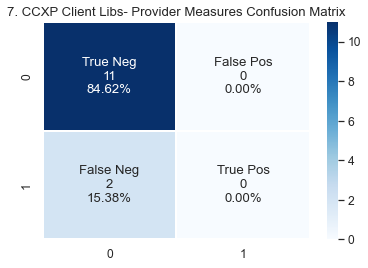

<Figure size 432x288 with 0 Axes>

In [49]:
# Label 7: pmeasures
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                ccxp_pmeasures_cm_plt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     ccxp_pmeasures_cm_plt.flatten()/np.sum(ccxp_pmeasures_cm_plt)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.subplot()
sns.set(font_scale=1.1) #edited as suggested
ax = sns.heatmap(ccxp_pmeasures_cm_plt ,cmap='Blues', linewidth = 0.25 , fmt='',annot = labels)
plt.title( "7. CCXP Client Libs- Provider Measures Confusion Matrix" )
plt.show()
plt.savefig('WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_CM_7_Provider_Measures-.png')

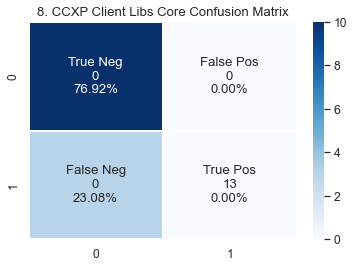

<Figure size 432x288 with 0 Axes>

In [50]:
# Label 8: cl_core
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                ccxp_server_cm_plt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     ccxp_cl_core_cm_plt.flatten()/np.sum(ccxp_cl_core_cm_plt)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.subplot()
sns.set(font_scale=1.1) #edited as suggested
ax = sns.heatmap(ccxp_cl_core_cm_plt ,cmap='Blues', linewidth = 0.25 , fmt='',annot = labels)
plt.title( "8. CCXP Client Libs Core Confusion Matrix" )
plt.show()
plt.savefig('WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_CM_8_Client_Libs_Core.png')

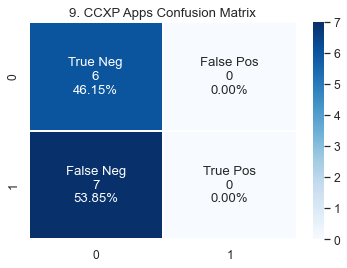

<Figure size 432x288 with 0 Axes>

In [51]:
# Label 9: Apps
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                ccxp_apps_cm_plt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     ccxp_apps_cm_plt.flatten()/np.sum(ccxp_apps_cm_plt)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.subplot()
sns.set(font_scale=1.1) #edited as suggested
ax = sns.heatmap(ccxp_apps_cm_plt ,cmap='Blues', linewidth = 0.25 , fmt='',annot = labels)
plt.title( "9. CCXP Apps Confusion Matrix" )
plt.show()
# export it
plt.savefig('WETG_AI_ML_BUG_AUTO_CCXP_RoBERTa_QA2_CM_9_Apps.png')